# LMO

We use LCO experimental data form the paper of [Bak](https://doi.org/10.1039/C1JM13741G).

## Data visualization

We import the libraries that we will use throughout this example

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

We load the data for the LMO and the $C_{rates}$ used.

In [2]:
C_rates = [1, 5, 10, 20, 50, 100]
dataframes = [pd.read_csv(f"data/bak/{crate}C.csv", header=None) for crate in C_rates]

we also define the equilibrium and cut-off potentials.

In [3]:
eq_pot = 4.0
vcut = 0.15

We plot the curves with the corresponding potentials as dashed horizontal lines.

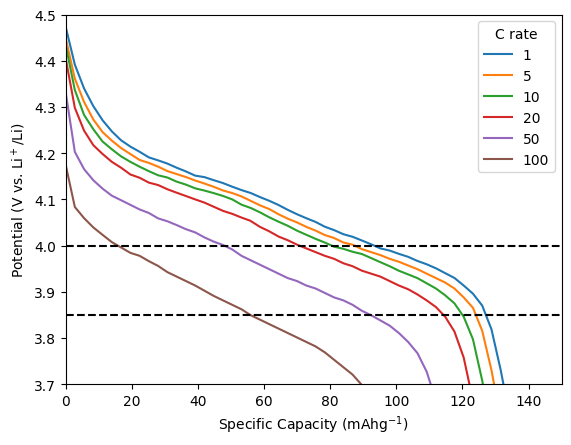

In [4]:
fig, ax = plt.subplots()

for crate, df in zip(C_rates, dataframes):
    ax.plot(df[0], df[1], label=f"{crate}")
    
ax.axhline(y=eq_pot, color="k", linestyle="--")
ax.axhline(y=eq_pot - vcut, color="k", linestyle="--")
    
ax.set_xlim((0, 150))
ax.set_ylim((3.7, 4.5))
ax.set_xlabel(r"Specific Capacity (mAhg$^{-1}$)")
ax.set_ylabel(r"Potential (V vs. Li$^+$/Li)")
ax.legend(title="C rate")
plt.show()

## Preprocessing

We can use the `preprocessing` module of `galpynostatic` to obtain the discharge capacities.

In [5]:
import galpynostatic
gdc = galpynostatic.preprocessing.GetDischargeCapacities(eq_pot)
xmaxs = gdc.fit_transform(dataframes)

We divide by the maximum value to obtain the currents between 0 and 1.

In [6]:
xmaxs = xmaxs / 132.4

and visualize the data for the fitting

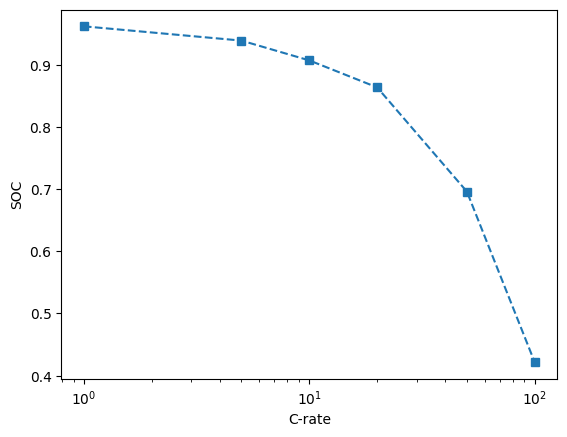

In [7]:
plt.plot(C_rates, xmaxs, marker="s", ls="--")

plt.xlabel("C-rate")
plt.ylabel("SOC")
plt.xscale("log")
plt.show()

## Fitting

In the paper it is mentioned that the particle sizes are distributed between $10-40 nm$, we take the mid point 

In [8]:
d = 2.5e-6

We load the surface data for spherical geometry

In [9]:
dataset = galpynostatic.datasets.load_spherical()

And fit on it

In [10]:
greg = galpynostatic.model.GalvanostaticRegressor(dataset, d, 3)

C_rates = np.asarray(C_rates).reshape(-1, 1)
greg.fit(C_rates, xmaxs)

## Results

The values obtained for the diffusion coefficient and the kinetic rate constant are

In [11]:
print(f"Diffusion coefficient: {greg.dcoeff_:.3e} cm^2/s")
print(f"Kinetic rate constant: {greg.k0_:.3e} cm/s")

Diffusion coefficient: 3.511e-14 cm^2/s
Kinetic rate constant: 1.874e-08 cm/s


with a mean squared error of

In [12]:
print(f"{greg.mse_:.6f}")

0.000434


We can estimate the optimal value for the characteristic length of the nanoparticle, i.e. the size to obtain 80% of the charge in 5 minutes.

In [13]:
new_d = galpynostatic.predict.t_minutes_length(greg)
print(f"{new_d:.6f} micrometers")

0.024714 micrometers


Now we can plot data versus predictions

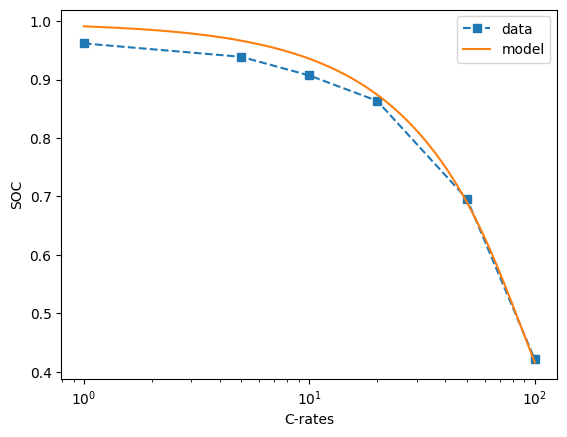

In [14]:
greg.plot.versus_data(C_rates, xmaxs)
plt.xscale("log")
plt.legend()
plt.show()

and the map region of the data

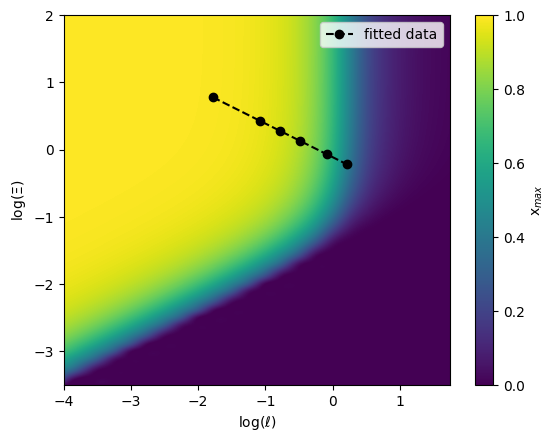

In [15]:
greg.plot.in_surface(C_rates)
plt.legend()
plt.show()